## Siamese Bidirectional LSTM for Finding the Supplier of OCR generated invoice

In [1]:
# !pip install --user pydot graphviz
# !pip install  pandas 
# !pip install --user nlpaug nltk
# !pip install --user tensorflow
# !pip install --upgrade --user gast==0.2.2


In [2]:
import logging
import pandas as pd
import ast
import numpy as np
from joblib import dump, load
import re
import string

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

K = tf.keras.backend
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

import nlpaug.augmenter.char as nac

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow.keras.regularizers  as reglzr
from nltk.corpus import reuters
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('reuters')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/mashallaryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mashallaryan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mashallaryan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /home/mashallaryan/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [3]:
MODEL_FILENAME = 'model.ml'

AUG_FILE = 'augfile.csv'
SUP_FILE ='supfile.csv'
MAXNUM_AUG = 1000

EMBEDDING_DIM = 50
VOCAB_SIZE = 5000
MAX_SEQ_LEN = 1000
LSTM_CODE_DIM = 50
NUM_HIDDEN = 50
BATCH_SIZE = 128
LOG_FILE = 'logfile.log'

In [4]:

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(LOG_FILE)
fh.setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

logger.addHandler(fh)
logger.addHandler(ch)

In [5]:


def read_invoice(file_name):
    """
    Reads a file of invoice content created by OCR and converts it to a pandas dataframe
    
    :param file_name: Name of the file containing invoice content
    :return: A dataframe of the invoice words 
    
    """
    with open(file_name,'r') as f:
        words = "[{}]".format(f.read().strip())
    words = words.replace("\n", ",")
    words = ast.literal_eval(words)
    inv_df = pd.DataFrame(words)
    # sort the words according to their order in the original doc
    inv_df = inv_df.set_index(['page_id','line_id','pos_id'])
    inv_df.sort_index(inplace=True)
    
    return ' '.join(inv_df['word'])


lemat = WordNetLemmatizer()
def clean(item):
    """
    preprocessing the input string to remove the unwanted characters and substrings     
    :param item: input string
    :return: a string in which unwanted characters and substrings are removed 
    
    """
    res = item.encode("ascii", errors="ignore").decode()

    res = re.sub('['+string.punctuation+']+','',res).strip()
    res = word_tokenize(res.lower())
    res = [lemat.lemmatize(item) for item in res if item not in stopwords.words('english')]    
    return   " ".join(res)


def build_tokenizer(docs):
    logger.info('build tokenizer.')
    uwords = set()
    docs.str.lower().str.split().apply(uwords.update)
    vocab_size = len(uwords)
    tknzr = Tokenizer(num_words=vocab_size, oov_token="<OOV>")    
    tknzr.fit_on_texts(uwords)    
    return tknzr



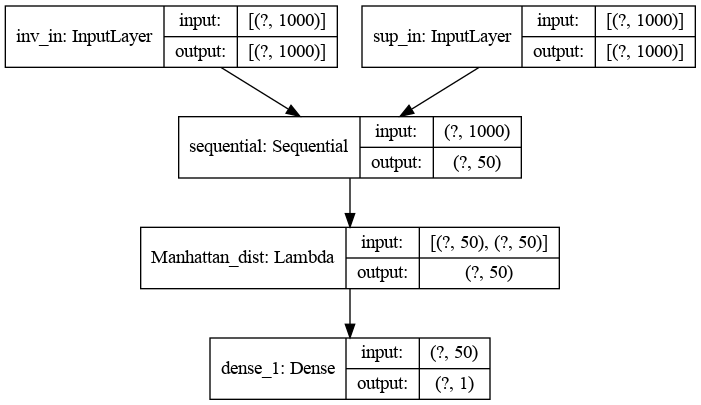

In [6]:
def build_model(num_hidden=100, dropout=0.2, recurrent_dropout=0.2):
    
    # Create the shared encoder
    encoder = models.Sequential()
    encoder.add(layers.Embedding(VOCAB_SIZE,EMBEDDING_DIM ,input_shape=(MAX_SEQ_LEN,)) )
    encoder.add(layers.Bidirectional(layers.LSTM(num_hidden, kernel_regularizer=reglzr.l2(1e-5), dropout=dropout, recurrent_dropout=recurrent_dropout)))
    encoder.add(layers.Dense(LSTM_CODE_DIM , kernel_regularizer=reglzr.l2(1e-5)))
    
    
    # Invoice input
    inv_in = layers.Input(shape=(MAX_SEQ_LEN,),dtype=tf.int32,name='inv_in')
    # Supplier input
    sup_in = layers.Input(shape=(MAX_SEQ_LEN,),dtype=tf.int32,name='sup_in')
    
    # Seperated encoders for invoice and supplier
    inv_encoder = encoder(inv_in)
    sup_encoder = encoder(sup_in)
    
    # loss layer
#     manhattan_dist = lambda x:K.sum(K.exp(- K.abs(x[0] - x[1]) ), axis=1)
    l1dist = (lambda x: K.abs(x[0] - x[1]) )
    L1_layer =  layers.Lambda(l1dist , name='Manhattan_dist')
    
    L1_distance = L1_layer([inv_encoder, sup_encoder])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = layers.Dense(1,activation='sigmoid')(L1_distance)
    
#     model = models.Model(inputs=[inv_in, sup_in], outputs=L1_distance)
#     model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=2e-5), metrics=['accuracy'])
    model = models.Model(inputs=[inv_in, sup_in], outputs=prediction)
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=2e-4), metrics=['accuracy'])

    return model
    
model = build_model()  
tf.keras.utils.plot_model(model,to_file='model.png',show_shapes=True)


In [7]:
def augment_data(suppliers):
    logger.info('Data Augmentation: this might take some time...')
    aug = nac.OcrAug()
    
   
    aug_df = []    
    for ind, row in suppliers.iterrows():    
        aug_df += [pd.DataFrame([[row['Id'],new_aug]],columns=['Id','SupplierName']) 
                   for new_aug in aug.augment(row['SupplierName'], n=MAXNUM_AUG) ]
    aug_df = pd.concat(aug_df+[suppliers[['Id','SupplierName']]]).reset_index(drop=True) 
    sup_df['Ind'] = sup_df.index
    return sup_df




def create_training_data(suppliers, n_samples_per_sup=10):
    """
    Given a dataframe of suppliers, creates a dataset of positive and negative pairs of invoice-supplier, given a dataframe of suppliers.
    
    :param suppliers: a dataframe (columns= ['Id', 'SupplierName' ]) of supplier names 
    :param n_samples_per_sup: number of positive and negative pairs generated per supplier name
    :return: a Dataframe (columns= ['invoice', 'SupplierName', 'label']) of invoice-supplier pairs 
             where the label=1 for a positive samples (invoice contains the supplier name) and label=0 
             if invoice does not contains the supplier name.
    """
    logger.info('Create Training Data...')

    def inject_pos(item):
        point = np.random.randint(0,len(item['invoice'])-1)
        
        item_text = item['invoice']
        item_num = item['Ind']
        return item_text[0:point]+' {} '.format(supplier_names[item_num]) + item_text[point:]
    
    # Pick some works from reuters corpus to build synthetic invoices later
    txt = nltk.Text(reuters.words())
    words =np.array(txt)[np.random.randint(0,1720901, 10000)]
    
    supplier_names = suppliers['SupplierName'].tolist()    
    num_suppliers = len(supplier_names)

    
    df_positive = []
    df_negative = []
    # Generate possitive and negative samples for each supplier 
    for i, row in suppliers.iterrows():
        df_positive += [pd.DataFrame([[row['Ind'],row['Id'],' '.join(words[np.random.randint(0,10000, np.random.randint(10, MAX_SEQ_LEN))].tolist() )]],columns=['Ind','Id','invoice']) for i in range(n_samples_per_sup)]
        df_negative += [pd.DataFrame([[row['Ind'],row['Id'],' '.join(words[np.random.randint(0,10000, np.random.randint(10, MAX_SEQ_LEN))].tolist() )]],columns=['Ind','Id','invoice']) for i in range(n_samples_per_sup)]
        
    df_positive = pd.concat(df_positive)     
    df_negative = pd.concat(df_negative)     
    
         
    #  For each positive sample inject the supplier name in a random place 
    df_positive['invoice'] = df_positive.apply(inject_pos,axis=1)   
    
    # Label the positive and negative samples
    df_positive['label'] = 0
    df_negative['label'] = 1
    
    # Pair the generated samples with supplier names
    df_all = pd.concat([df_positive, df_negative])   
    df_all= df_all.rename(columns={"Id": "SupId"})
    df_all = suppliers.merge( df_all , left_on='Id', right_on='SupId')
    return df_all[['Id','invoice', 'SupplierName', 'label']]
#     return df_all#[['Id','invoice', 'SupplierName', 'label']]
    
# Test
# sup_df = pd.read_csv('suppliernames.txt')
# sup_df['SupplierName'] = sup_df['SupplierName'].apply(clean)


# sup_aug_df = augment_data(sup_df)


# num_sample_per_supplier = 1
# dataset_df = create_training_data(sup_aug_df, num_sample_per_supplier)

# test_df1 = dataset_df[dataset_df['SupplierName'].str.contains('demo company')]
# test_df2 = sup_aug_df[sup_aug_df['SupplierName'].str.contains('demo company')]

# assert test_df1['SupplierName'].count() == 2* num_sample_per_supplier * test_df2['SupplierName'].count()
# assert test_df1[test_df1['label']==0]['invoice'].str.contains('demo company').values[0]
# assert  not test_df1[test_df1['label']==1]['invoice'].str.contains('demo company').values[0]
    


In [8]:
def train(dataset_df , epochs=5,  num_sample_per_supplier=5):
    logger.info('Init Training...')
    
   
    X = dataset_df[['invoice', 'SupplierName']]
    Y = dataset_df['label']
    
    
    tknzr = build_tokenizer(X['SupplierName'])
    invoices =tknzr.texts_to_sequences(X['invoice'].str.split().values)
    suppliers = tknzr.texts_to_sequences(X['SupplierName'].str.split().values)    
    invoices  = pad_sequences(invoices,maxlen=MAX_SEQ_LEN)
    suppliers  = pad_sequences(suppliers,maxlen=MAX_SEQ_LEN)

    dataset = tf.data.Dataset.from_tensor_slices(({'inv_in':tf.cast(invoices,tf.int32),'sup_in':tf.cast(suppliers,tf.int32)} ,tf.cast( Y.values, tf.int32)))
      
    dataset = dataset.shuffle(len(dataset_df)).batch(BATCH_SIZE).repeat()
    
    logger.info('Build model...')
    model = build_model()
    logger.info('Start training for {} epochs...'.format(epochs))    
    model.fit(dataset,  epochs=epochs, steps_per_epoch= X['SupplierName'].count()//BATCH_SIZE)   
    
    return model, tknzr 
    

In [9]:

def predict(model, tknzr,suppliers_df, sup_aug_df, query):
    

    suppliers = tknzr.texts_to_sequences(sup_aug_df['SupplierName'].str.split().values)    
    suppliers  =tf.cast( pad_sequences(suppliers,maxlen=MAX_SEQ_LEN), tf.int32)
    query = clean(query )
    query = tknzr.texts_to_sequences([query])
    query = tf.cast(pad_sequences(query,maxlen=MAX_SEQ_LEN),tf.int32)
      
    result =np.array([model.predict([tf.reshape(query[0],shape=(1,-1)), tf.reshape(supplier,shape=(1,-1))]) for i,supplier in enumerate(suppliers)])
    result = result.ravel()

    sup_id = sup_aug_df.iloc[ np.argmin(result)]['Id']
    supplier = suppliers_df[suppliers_df['Id']==sup_id]
    
    return suppliers_df['Id'].values[0], suppliers_df['SupplierName'][0]
    

    
        


# Test the model 

In [10]:

sup_df = pd.read_csv('suppliernames.txt')
sup_df['SupplierName'] = sup_df['SupplierName'].apply(clean)


sup_aug_df = augment_data(sup_df)


num_sample_per_supplier = 500
dataset_df = create_training_data(sup_aug_df, num_sample_per_supplier)


model, tknzr  = train(dataset_df, epochs=50 )


Data Augmentation: this might take some time...
Create Training Data...
Init Training...
build tokenizer.
Build model...
Start training for 50 epochs...


Train for 718 steps
Epoch 1/50
 62/718 [=>............................] - ETA: 25:01 - loss: 0.6959 - accuracy: 0.4976

KeyboardInterrupt: 

In [ ]:
query = read_invoice('invoice.txt')
query = clean(query)

predict(model, tknzr, sup_df, sup_aug_df, query)

In [11]:
!pwd


/local/scratch/mashall/scratch/Myprojects/Find_supplier
